In [1]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import TweetTokenizer, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, make_scorer
from wordcloud import WordCloud

import matplotlib.pyplot as plt
import seaborn as sns

from code.cleaner import preprocess
from code.viz import word_plot

sns.set()

In [2]:
sentiments = pd.read_csv('./data/judge-1377884607_tweet_product_company.csv',encoding='ISO-8859-1')
sentiments.tail()

tweet_text  \
9088                      Ipad everywhere. #SXSW {link}   
9089  Wave, buzz... RT @mention We interrupt your re...   
9090  Google's Zeiger, a physician never reported po...   
9091  Some Verizon iPhone customers complained their...   
9092  Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...   

     emotion_in_tweet_is_directed_at  \
9088                            iPad   
9089                             NaN   
9090                             NaN   
9091                             NaN   
9092                             NaN   

     is_there_an_emotion_directed_at_a_brand_or_product  
9088                                   Positive emotion  
9089                 No emotion toward brand or product  
9090                 No emotion toward brand or product  
9091                 No emotion toward brand or product  
9092                 No emotion toward brand or product

In [3]:
# sentiments['product'] = sentiments['emotion_in_tweet_is_directed_at']
# sentiments['sentiment'] = sentiments['is_there_an_emotion_directed_at_a_brand_or_product']

sentiments.rename(columns={
    'emotion_in_tweet_is_directed_at':'product',
    'is_there_an_emotion_directed_at_a_brand_or_product':'sentiment'
},inplace=True)

In [4]:
sentiments.dropna(subset=['tweet_text'],inplace=True)

In [5]:
sentiments['sentiment'].value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: sentiment, dtype: int64

Here, we'll split off the sentiments listed as "I can't
tell" into their own dataframe and drop them from the
original.

In [6]:
reclassify = sentiments[sentiments['sentiment'] == "I can't tell"]
sentiments = sentiments[sentiments['sentiment'] != "I can't tell"]

In [7]:
sw = stopwords.words('english')
specific_words = ['@mention','link','sxsw','#sxsw','@sxsw']
# ^^ these are the original extended stop words from initial data
# discovery and knowledge 
discovered_words = [
    'google','iphone', 'ipad', 'android', 'app',
    'apple', 'rt', 'quot', 'store', 'new', 'austin'
    ]
specific_words.extend(discovered_words)
sw.extend(specific_words)

In [8]:
preprocess(sentiments['tweet_text'],sw)

['@wesley g hr tweet #rise dead need upgrade plugin station',
 '@jessedee know @fludapp awesome likely appreciate design also give free t',
 '@swonderlin wait #ipad also sale',
 'hope year festival crashy year',
 '@sxtxstate great stuff fri marissa mayer tim reilly tech book conference amp matt mullenweg wordpress',
 '@teachntech apps #speechtherapy communication showcased conference http ht ly n #iear #edchat #asd',
 'start #ctia around corner #googleio hop skip jump good time #android fan',
 'beautifully smart simple idea @madebymany @thenextweb write #hollergram http bit ly ieavob',
 'counting day plus strong canadian dollar mean stock gear',
 'excited meet @samsungmobileus show sprint galaxy still run #fail',
 'find amp start impromptu party @hurricaneparty http bit ly gvlrin wait til come',
 'foursquare ups game time http j mp grn pk still prefer @gowalla far best look date',
 'gotta love calendar feature top party show case check @hamsandwich via @ischafer gt http bit ly axzwxb',

In [9]:
sentiments['tokenized'], sentiments['tokens'] = \
    preprocess(sentiments['tweet_text'],sw=sw,ret_tokens=True)

In [10]:
X = sentiments[['tokenized','tokens']]
y = sentiments['sentiment']

X_train, X_test, y_train, y_test = \
    train_test_split(X,y,
        test_size=0.2,
        stratify=y,random_state=13)

train = X_train.merge(
    y_train,left_index=True,right_index=True
    )
test = X_test.merge(
    y_test,left_index=True,right_index=True
    )

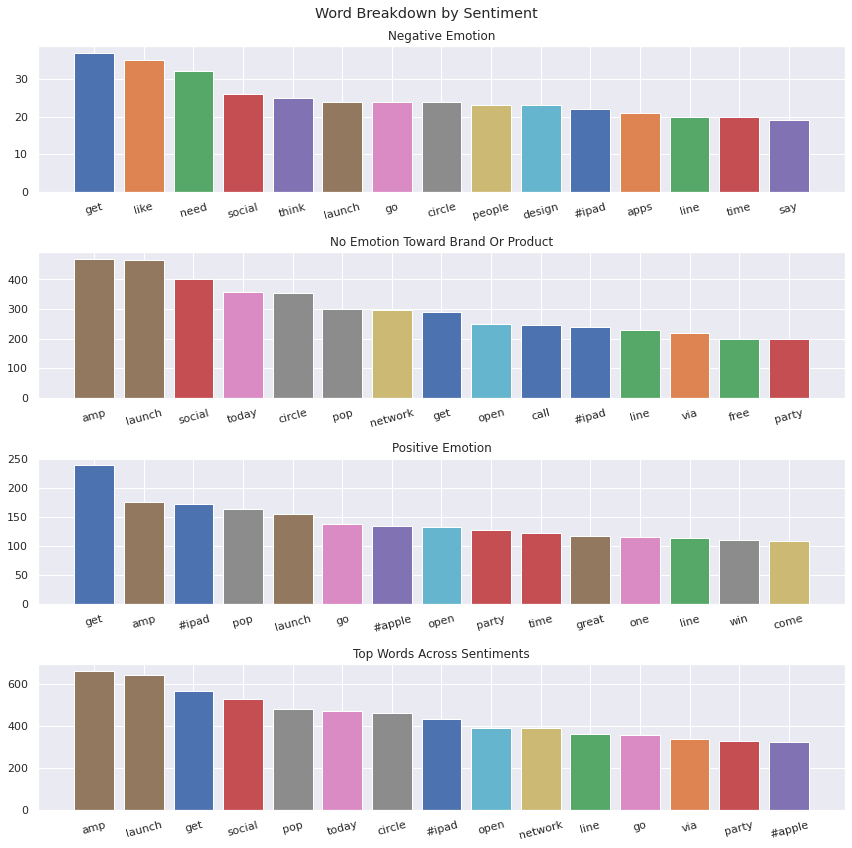

In [11]:
# train = X_train.merge(
#     y_train,left_index=True,right_index=True
#     )
freq_words = word_plot(train,'sentiment','tokens',
    n_words=15)

Index(['#ipad', 'get', 'launch', 'line'], dtype='object')


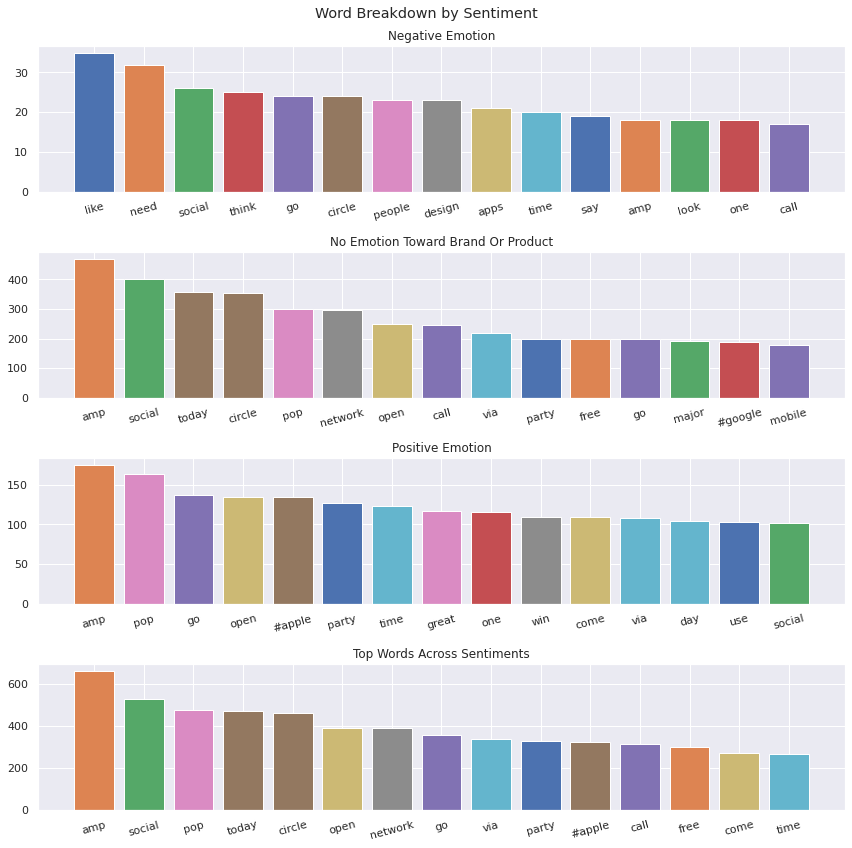

In [12]:
print(freq_words[1])
sw.extend(freq_words[1])
train['tokenized'], train['tokens'] = preprocess(train['tokenized'],sw,ret_tokens=True)
freq_words = word_plot(train,'sentiment','tokens',
    n_words=15)

Index(['amp', 'go', 'social'], dtype='object')


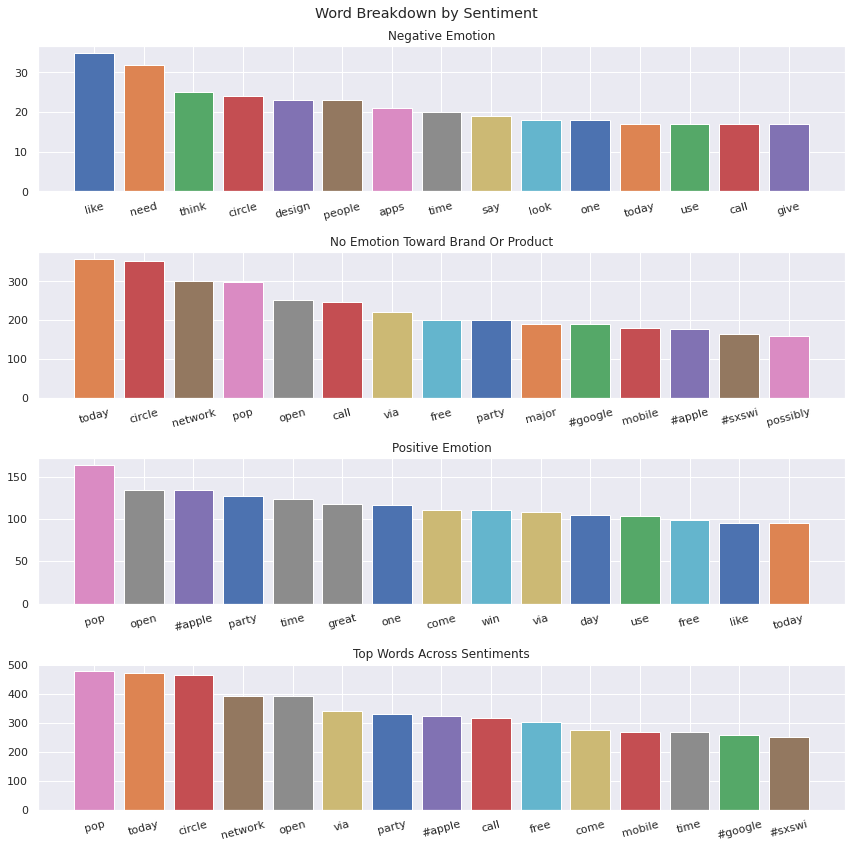

In [13]:
print(freq_words[1])
sw.extend(freq_words[1])
train['tokenized'], train['tokens'] = preprocess(train['tokenized'],sw,ret_tokens=True)
freq_words = word_plot(train,'sentiment','tokens',
    n_words=15)

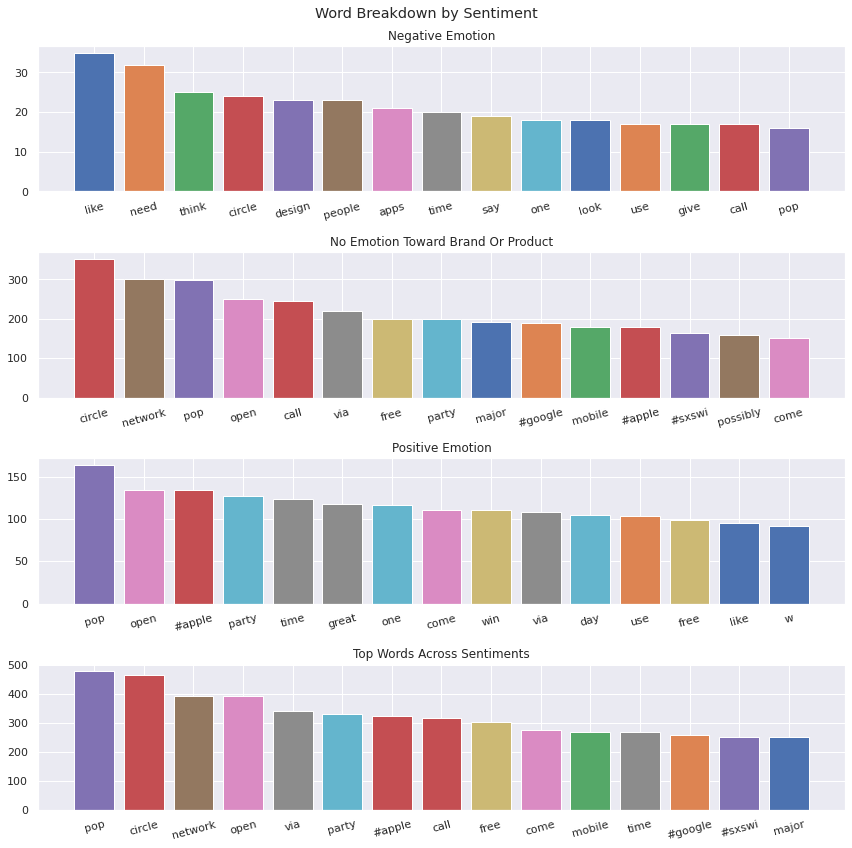

In [14]:
sw.extend(freq_words[1])
train['tokenized'], train['tokens'] = preprocess(train['tokenized'],sw,ret_tokens=True)
freq_words = word_plot(train,'sentiment','tokens',
    n_words=15)

In [15]:
freq_words[1]

Index(['pop'], dtype='object')

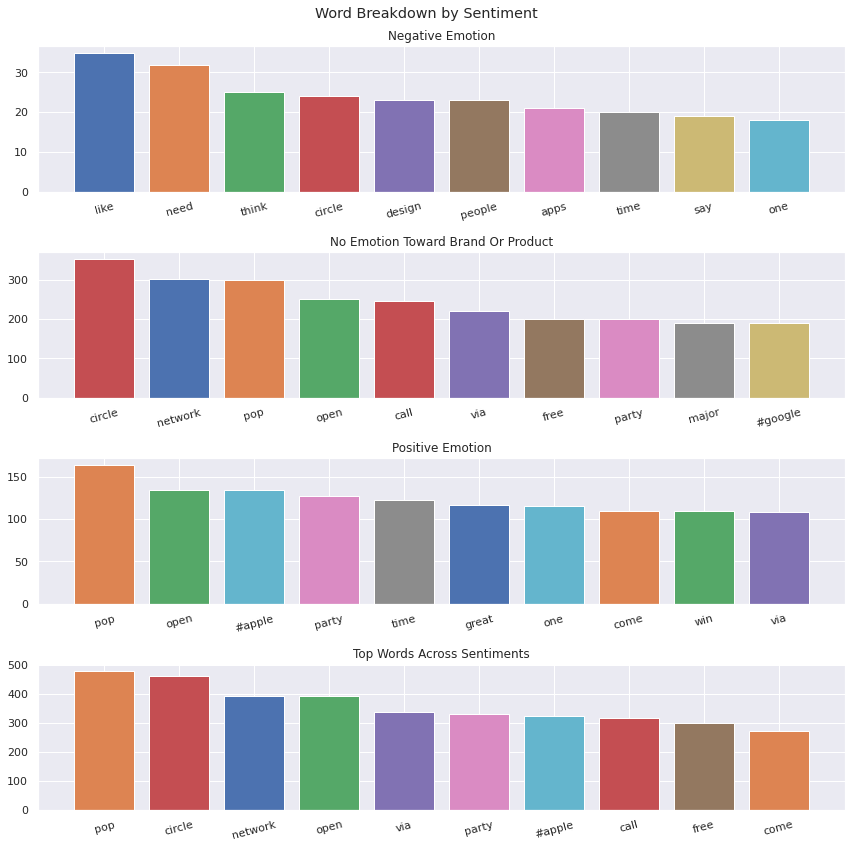

In [16]:
word_plot(train,'sentiment','tokens');

In [17]:
tfidf = TfidfVectorizer(ngram_range=[1,3],max_df=0.4,min_df=20)
train_tfidf = tfidf.fit_transform(train['tokenized'])
# X = tfidf.fit_transform(sentiment_tokens)
train_vec = pd.DataFrame(train_tfidf.toarray(),columns=tfidf.get_feature_names())

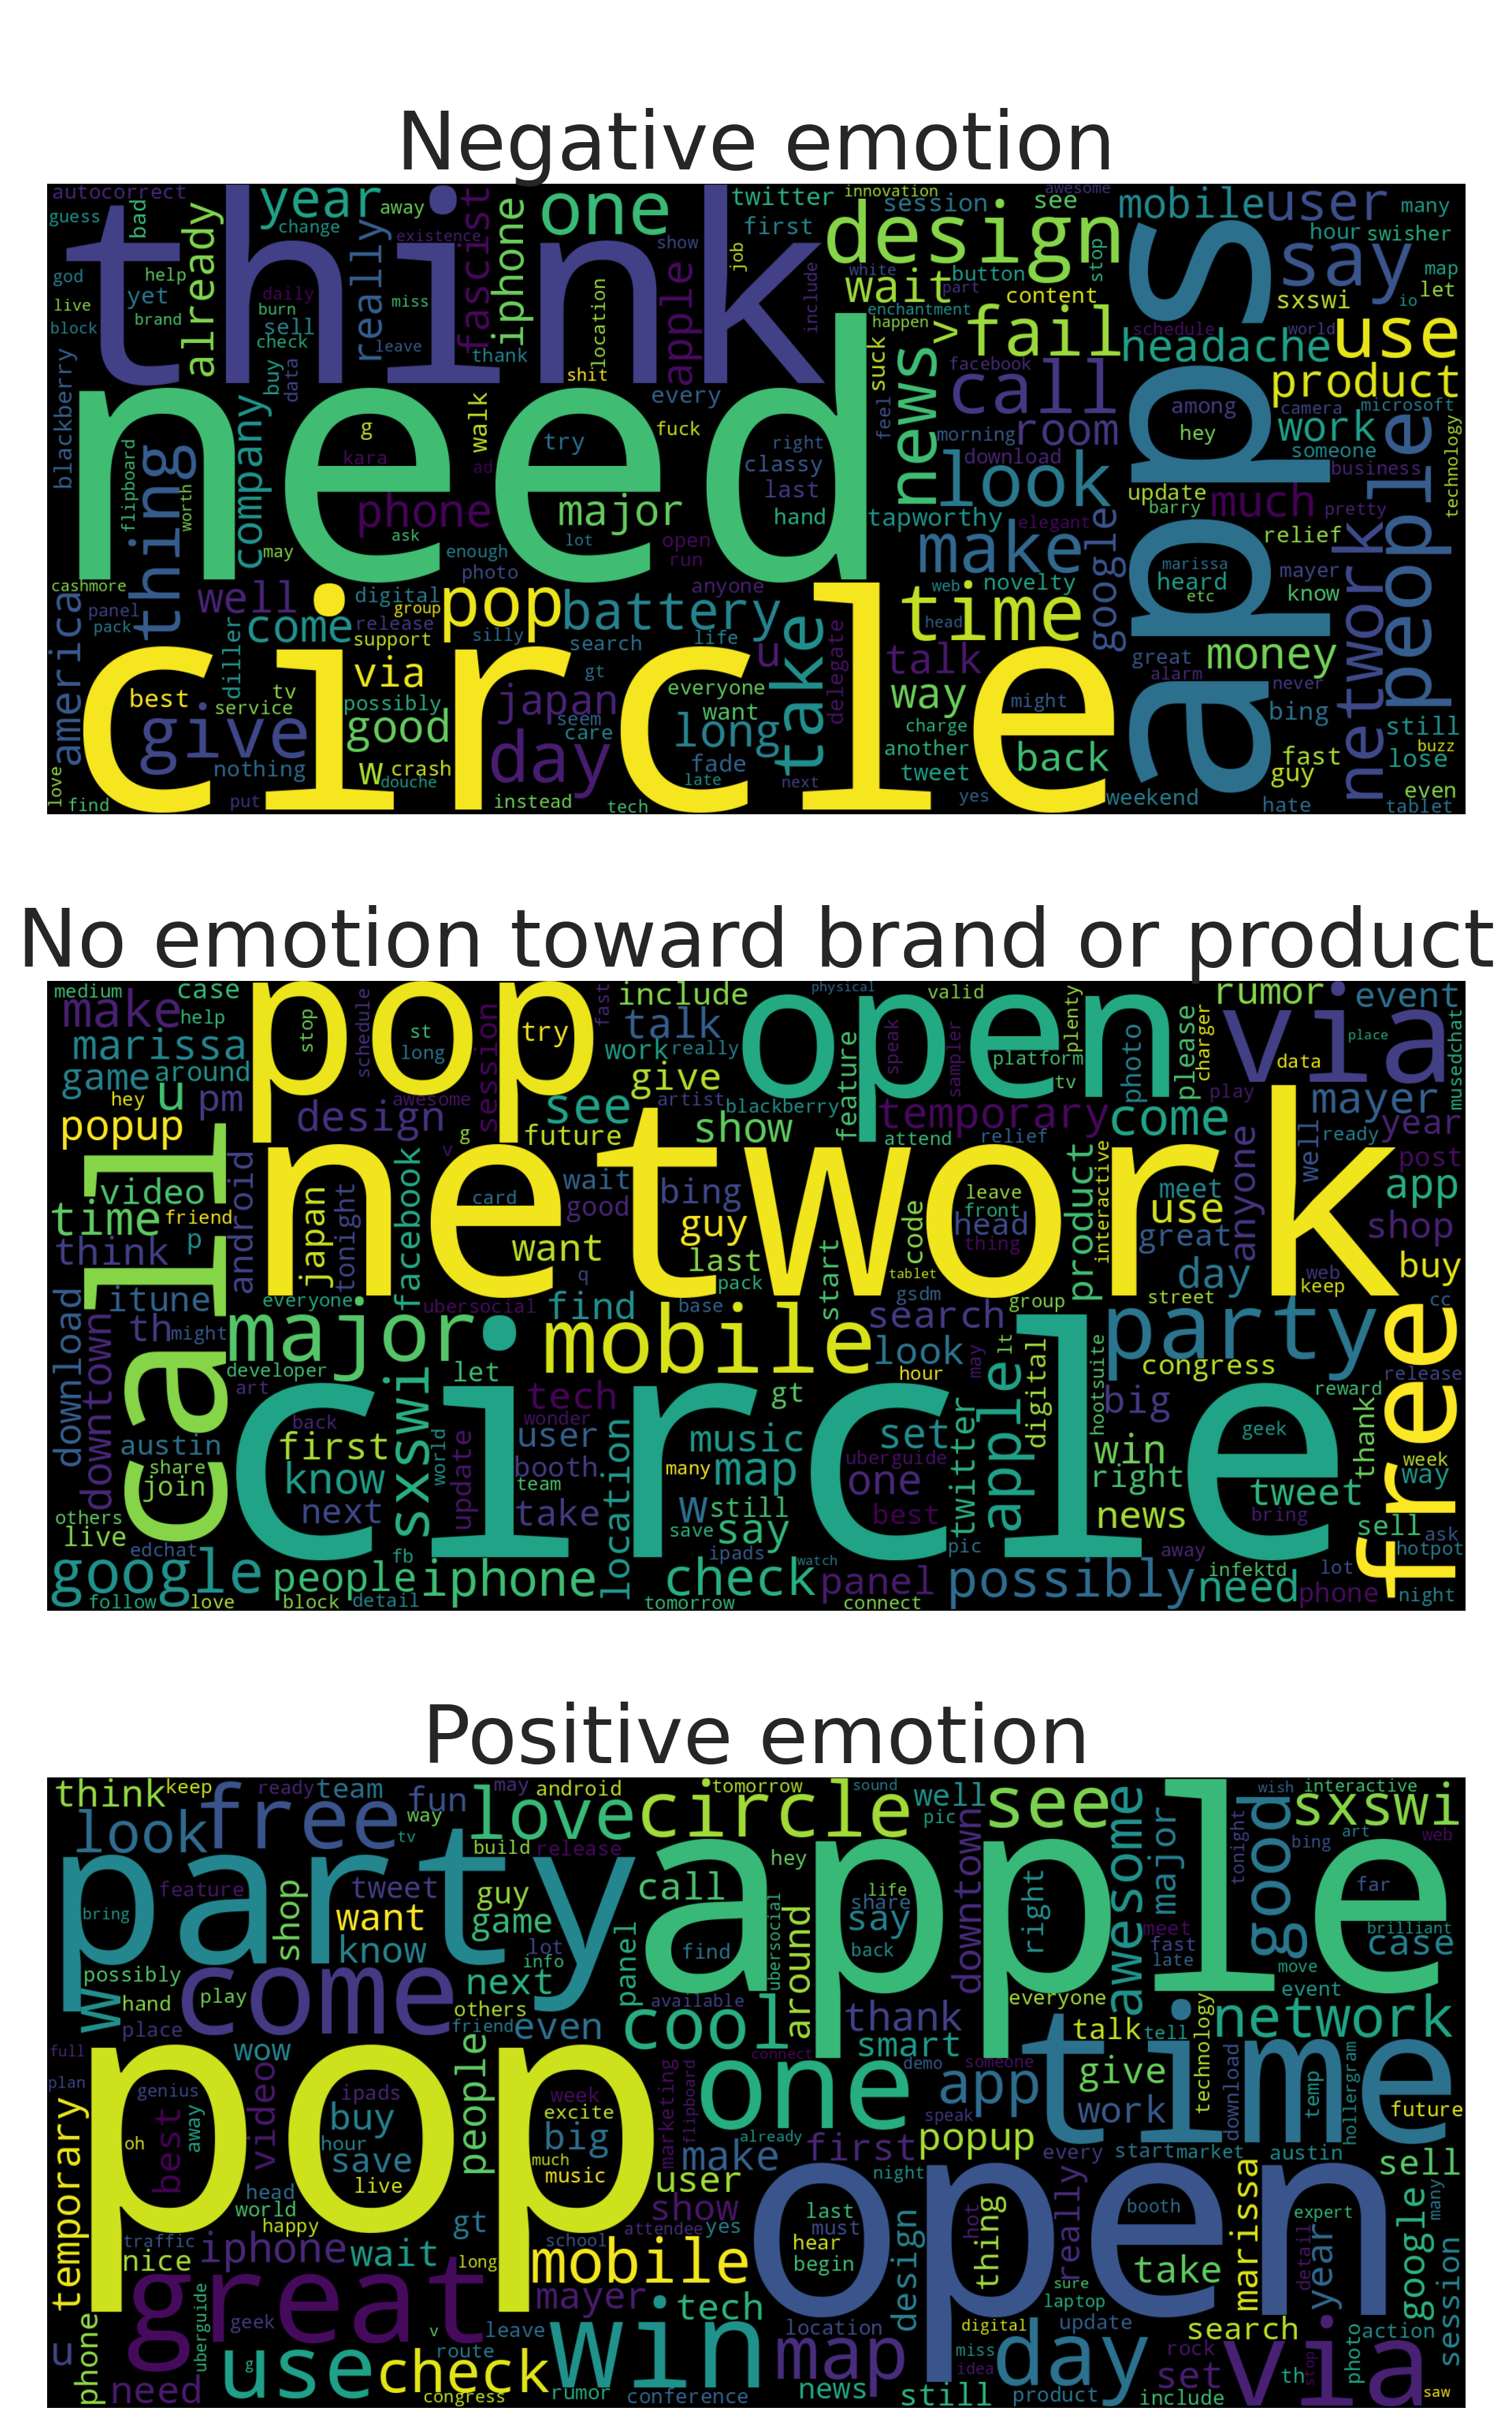

In [44]:
fig, ax = plt.subplots(3,1,figsize=(10,14),dpi=250)
for i, emo in enumerate(train['sentiment'].unique()):
    tmp_ = train[train['sentiment'] == emo]
    ax_ = ax[i]
    wordcloud = WordCloud(
        collocations=False, width=1800,height=800
        ).generate(' '.join(tmp_['tokenized']))
    ax_.set_title(f"\n{emo}",fontsize=34)
    ax_.imshow(wordcloud, interpolation='bilinear')
    ax_.axis('off')
plt.tight_layout(pad=0)

We can see that the word "Circle" appears at a high
volume in every category. Looking through the data,
this is because Google launched a social network called
"Circle" that was a large topic during the SXSW event
that was taking place during the time of our dataset's
collection.

In [47]:
sw.extend(['circle'])
train['tokenized'],train['tokens'] = \
    preprocess(train['tokenized'],sw,ret_tokens=True)